# Détection de nuages sur des images Pléiades avec 3 bandes RGB.

## Packages et données

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q

In [3]:
!pip install scikit-image

In [93]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
from image_utils import *
from mappings import *
from filter import *

In [3]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import re
from pyproj import Transformer
from datetime import date
from scipy.ndimage import label
import time
from tqdm import tqdm
import os

In [5]:
import math

In [4]:
import geopandas as gpd
from shapely.geometry import Polygon
from rasterio.features import rasterize, shapes

In [6]:
update_storage_access()

In [7]:
environment = get_environment()

root_path = get_root_path()

bucket = environment["bucket"]

#2022
#guyane 2022
path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]

#martinique 2022
path_s3_pleiades_data_2022_martinique = environment["sources"]["PLEIADES"][2022]["martinique"]
path_local_pleiades_data_2022_martinique = environment["local-path"]["PLEIADES"][2022]["martinique"]
          
#guadeloupe 2022
path_s3_pleiades_data_2022_guadeloupe = environment["sources"]["PLEIADES"][2022]["guadeloupe"]
path_local_pleiades_data_2022_guadeloupe = environment["local-path"]["PLEIADES"][2022]["guadeloupe"]

#mayotte 2022
path_s3_pleiades_data_2022_mayotte = environment["sources"]["PLEIADES"][2022]["mayotte"]
path_local_pleiades_data_2022_mayotte = environment["local-path"]["PLEIADES"][2022]["mayotte"]

#2020
#mayotte 2020
path_s3_pleiades_data_2020_mayotte = environment["sources"]["PLEIADES"][2020]["mayotte"]
path_local_pleiades_data_2020_mayotte = environment["local-path"]["PLEIADES"][2020]["mayotte"]

#2019
#mayotte 2019
path_s3_pleiades_data_2019_mayotte = environment["sources"]["PLEIADES"][2019]["mayotte"]
path_local_pleiades_data_2019_mayotte = environment["local-path"]["PLEIADES"][2019]["mayotte"]

#2018
#reunion 2018
path_s3_pleiades_data_2018_reunion = environment["sources"]["PLEIADES"][2018]["reunion"]
path_local_pleiades_data_2018_reunion = environment["local-path"]["PLEIADES"][2018]["reunion"]

#2017
#martinique 2017
path_s3_pleiades_data_2017_martinique = environment["sources"]["PLEIADES"][2017]["martinique"]
path_local_pleiades_data_2017_martinique = environment["local-path"]["PLEIADES"][2017]["martinique"]

#mayotte 2017
path_s3_pleiades_data_2017_mayotte = environment["sources"]["PLEIADES"][2017]["mayotte"]
path_local_pleiades_data_2017_mayotte = environment["local-path"]["PLEIADES"][2017]["mayotte"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

In [10]:
# DL PLEIADE mayotte 2020
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2020_mayotte}",
        lpath=f"../{path_local_pleiades_data_2020_mayotte}",
        recursive=True)

## Exemple d'une image avec un nuage

Voici un exemple d'une image avec un nuage

In [8]:
#image avec nuage 
filename_3 = '../data/PLEIADES/2020/MAYOTTE/ORT_2020052526656219_0508_8599_U38S_8Bits.jp2' 
date_3 = date.fromisoformat('2020-01-01')

In [88]:
image_3 = SatelliteImage.from_raster(
        filename_3,
        date = date_3, 
        n_bands = 3,
        dep = "976"
    )
image_3.normalize()

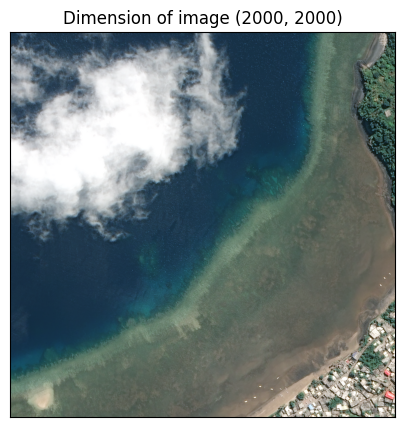

In [12]:
image_3.plot([0,1,2]) 

## Masque de coeur de nuages (uniquement le centre du nuage)

Cette fonction peut s'appliquer pour détecter le coeur du nuage mais aussi le nuage entier (tout dépend du seuil fixé).

In [137]:
def plot_nuage(image, threshold, min_size):
    image = image.array.copy()

    image = image[[0,1,2],:, :]

    image = (image*255).astype(np.uint8)

    image = image.transpose(1, 2, 0)

    # Convertir l'image RGB en niveau de gris
    grayscale = np.mean(image, axis=2)

    # Trouver les amas de pixels blancs correspondant à 5% ou plus de l'image
    #threshold = 250  # seuil pour considérer un pixel comme "blanc"

    labeled, num_features = label(grayscale > threshold)

    region_sizes = np.bincount(labeled.flat)[:]

    # Trier les labels de région en fonction de leur taille décroissante
    sorted_labels = np.argsort(-region_sizes)


    # Minimum size of the cluster
    mask = np.zeros_like(labeled)

    if num_features >= 1:
        for i in tqdm(range(1, num_features + 1)): # Display the progress bar
            if region_sizes[sorted_labels[i]] >= min_size:
                mask[labeled == sorted_labels[i]] = 1
            else:
                break

    # Afficher l'image originale et l'image résultante côte à côte
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image)
    ax1.set_title("Image originale")
    ax2.imshow(mask)
    ax2.set_title("Image avec les amas de pixels blancs en rouge")
    plt.show()

D'abord, nous allons choisir un seuil de niveau de gris élevé pour ne détecter que les centre de nuages. Cela nous permet de détecter le moins possible d'objets hors nuages car on va se restreindre aux zones presque blanches pures et avec une taille d'amas de pixels de taille 50 000.

On veut que l'amas de pixels soit de taille minimale 50 000 pour qu'il soit pris en compte. En effet, il faut que l'amas soit suffisement grand pour être considéré comme nuage. Ce seuil a été choisi en regardant différentes tailles minimales d'amas sur l'image_3.

### Tests de différents seuils

  0%|          | 1/412 [00:00<00:01, 341.06it/s]


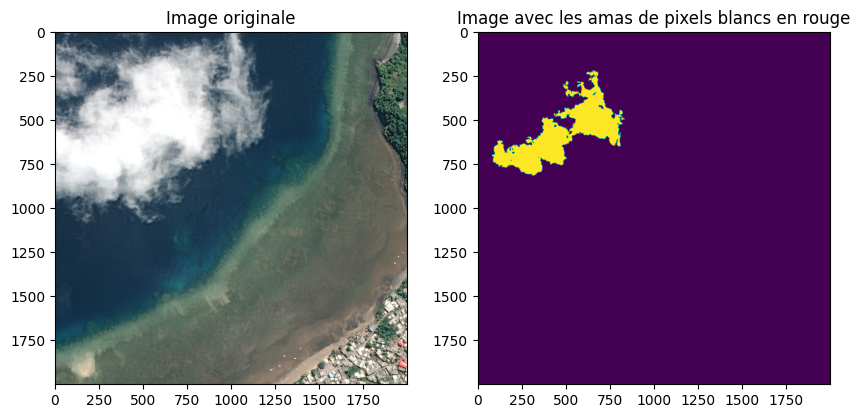

In [138]:
plot_nuage(image_3, 250, 50000)

100%|██████████| 2666/2666 [00:09<00:00, 276.07it/s]


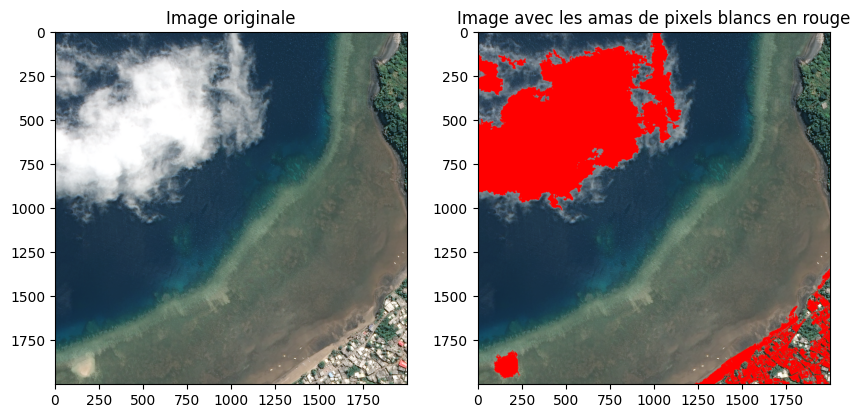

In [24]:
plot_nuage(image_3, 140, 2500)

100%|██████████| 2666/2666 [00:09<00:00, 285.13it/s]


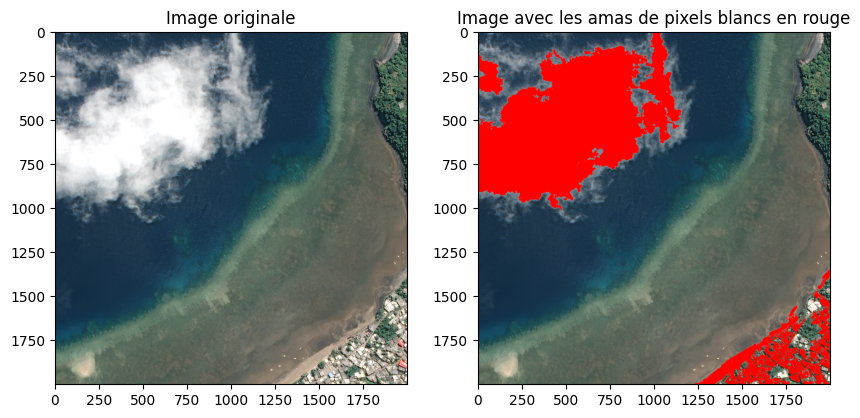

In [63]:
plot_nuage(image_3, 140, 20000)

100%|██████████| 412/412 [00:01<00:00, 271.87it/s]


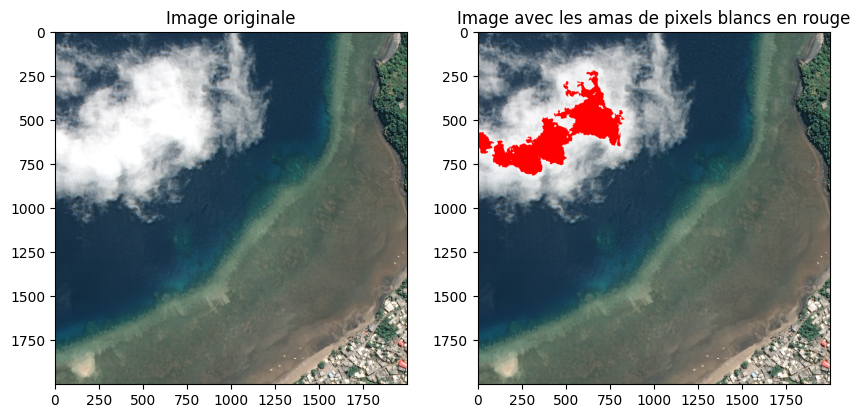

In [26]:
plot_nuage(image_3, 250, 2500)

## Détection de nuages sur un ensemble d'images

Voici une fonction de détection de nuages dans un échantillon d'un dossier d'images. On précise le département, l'année et la taille d'échantillon. Avec cette fonction, nous allons pouvoir tester la détection de nuages sur une liste d'images et on va controler visuellement pour avoir une matrice de confusion.

In [54]:
def detect_nuage_folder_sample(dep, millesime, threshold, min_size, sample_size_begin, sample_size_end):
    environment = get_environment()
    folder_path = "../" + environment["local-path"]["PLEIADES"][int(millesime)][dep.lower()]
    clouds = []
    filenames = os.listdir(folder_path)[sample_size_begin:sample_size_end]
    num_dep = name_dep_to_num_dep[dep.upper()]
    
    for filename in tqdm(filenames):
        try :
            image = SatelliteImage.from_raster(
                    folder_path + '/' +filename,
                    date = date.fromisoformat(str(int(millesime))+'-01-01'), 
                    n_bands = 3,
                    dep = num_dep
                    )
            image.normalize()
            
            cloud = has_cloud(image, threshold, min_size)

            if cloud:
                clouds.append(filename)

        except RasterioIOError:
            print("L'image "+filename+" ne s'ouvre pas.")
            
        finally :
            continue
            
    return(clouds)

Commenter les choix de seuils :

250 : avoir les pixels presque blanc pur

In [50]:
nuages_echantillon = detect_nuage_folder_sample("mayotte", 2020, threshold = 250, min_size = 50000, sample_size_begin=0, sample_size_end=100)
len(nuages_echantillon)

100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


10

10% d'images prédites avec des nuages.

In [56]:
nuages_echantillon_1 = detect_nuage_folder_sample("mayotte", 2020, threshold = 250, min_size = 50000, sample_size_begin=100, sample_size_end=200)
len(nuages_echantillon_1)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


8

In [41]:
nuages_echantillon1 = detect_nuage_folder_sample("mayotte", 2020, threshold = 250, min_size = 2500, sample_size = 100)
len(nuages_echantillon1)

100%|██████████| 100/100 [01:19<00:00,  1.27it/s]


34

34% d'images prédites avec des nuages.

140 : avoir les nuances de gris clair

In [51]:
nuages_echantillon2 = detect_nuage_folder_sample("mayotte", 2020, threshold = 140, min_size = 20000, sample_size = 100)
len(nuages_echantillon2)

100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


89

89% d'images prédites avec des nuages.

200 : avoir les nuances de gris très clair

In [52]:
nuages_echantillon3 = detect_nuage_folder_sample("mayotte", 2020, threshold = 200, min_size = 20000, sample_size = 100)
len(nuages_echantillon3)

100%|██████████| 100/100 [04:22<00:00,  2.63s/it]


41

41% d'images prédites avec des nuages.

Voici une fonction qui permet de parcourir tout un dossier d'images d'un certain département et d'un certain millésime pour retourner les images considérées comme contenant un ou des nuages. Nous allons essayer de prédire les images contenant des nuages dans le dossier Mayotte 2020 et on retient les seuils suivants  pixels_gris > 250 et amas_pixels > 20 000.

In [34]:
def detect_nuage_folder(dep, millesime, threshold, min_size):
    environment = get_environment()
    folder_path = "../" + environment["local-path"]["PLEIADES"][int(millesime)][dep.lower()]
    clouds = []
    filenames = os.listdir(folder_path)
    num_dep = name_dep_to_num_dep[dep.upper()]
    
    for filename in tqdm(filenames):
        try :
            image = SatelliteImage.from_raster(
                    folder_path + '/' +filename,
                    date = date.fromisoformat(str(int(millesime))+'-01-01'), 
                    n_bands = 3,
                    dep = num_dep
                    )
            image.normalize()
            
            cloud = has_cloud(image)

            if cloud:
                clouds.append(filename)

        except RasterioIOError:
            print("L'image "+filename+" ne s'ouvre pas.")
            
        finally :
            continue
            
    return(clouds)

In [35]:
nuages = detect_nuage_folder("mayotte", 2020, threshold = 250, min_size = 20000)

100%|██████████| 962/962 [11:58<00:00,  1.34it/s]


In [36]:
len(nuages)

160

160 nuages sur 962 images, soit 17% d'images contenant au moins un nuage.

## Fonction d'affichage d'une liste d'images afin de vérifier visuellement les résultats

On va créer une fonction pour afficher une liste d'images sur une fenêtre (suivant l'ordre dans la liste) pour pouvoir contrôler visuellement les résultats des détections de nuages.

Attention ! La longueur liste d'images doit être un entier carré. Ex : 1,4,9,16,25...

In [122]:
def plot_list_path_square(list_filepaths, dep, millesime):
    environment = get_environment()
    folder_path = "../" + environment["local-path"]["PLEIADES"][int(millesime)][dep.lower()]
    
    size = int(math.sqrt(len(list_filepaths)))
    bands_indices = [0,1,2]

    list_images = []

    for filepath in list_filepaths:

    # Retrieve left-top coordinates of all images
            image = SatelliteImage.from_raster(
                    folder_path + "/" + filepath,
                    date = date.fromisoformat(str(millesime) + '-01-01'), 
                    n_bands = len(bands_indices),
                    dep = name_dep_to_num_dep[dep.upper()]
                )
            image.normalize()
            list_images.append(image)

    mat_list_images = np.transpose(np.array(list_images).reshape(size,size))


    # Create a figure and axes
    fig, axs = plt.subplots(nrows=size, ncols=size, figsize=(10,10))

    # Iterate over the grid of masks and plot them
    for i in range(size):
        for j in range(size):
            axs[i, j].imshow(
                mat_list_images[i, j].array.transpose(1,2,0)
            )

    # Remove any unused axes
    for i in range(size):
        for j in range(size):
            axs[i, j].set_axis_off()

    # Show the plot
    plt.show()


Regardons le nombre d'images contenant réellement des nuages dans l'échantilon de taille 100 du dossier Mayotte 2020. On va afficher 25 images 25 images.

/opt/mamba/lib/python3.10/site-packages/rasterio/plot.py:345: RuntimeWarning: invalid value encountered in divide
  return (band - imin) / (imax - imin)


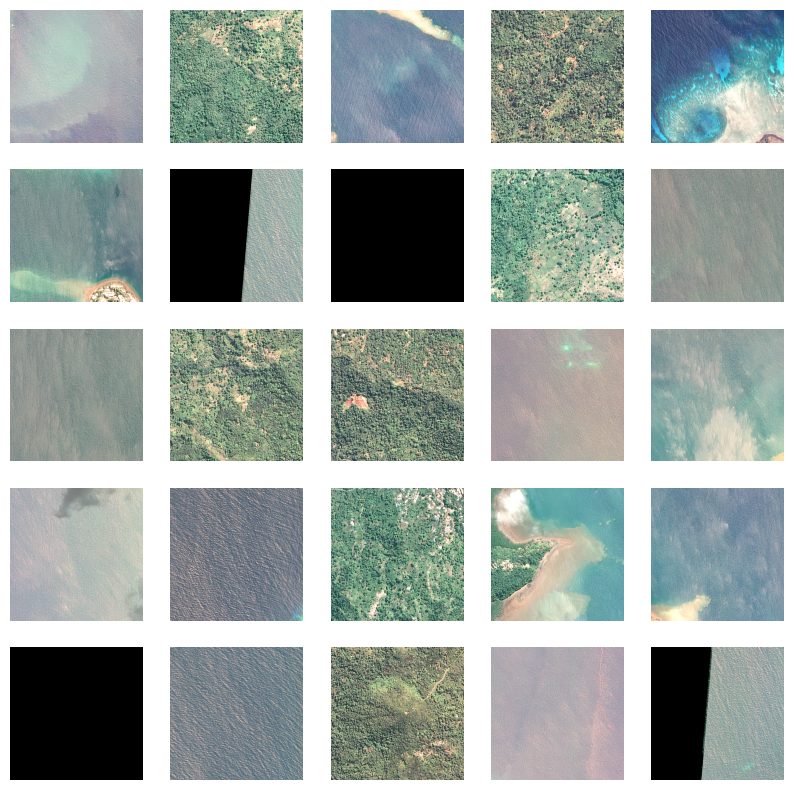

In [124]:
plot_list_path_square(os.listdir('../data/PLEIADES/2020/MAYOTTE')[0:25], "mayotte", 2020)
#plot_list_path_square(os.listdir('../data/PLEIADES/2020/MAYOTTE')[25:50], "mayotte", 2020)
#plot_list_path_square(os.listdir('../data/PLEIADES/2020/MAYOTTE')[50:75], "mayotte", 2020)
#plot_list_path_square(os.listdir('../data/PLEIADES/2020/MAYOTTE')[75:100], "mayotte", 2020)

Il y a 5 images avec des nuages dans l'échantillon de taille 100, soit 5% d'images contenant des nuages.

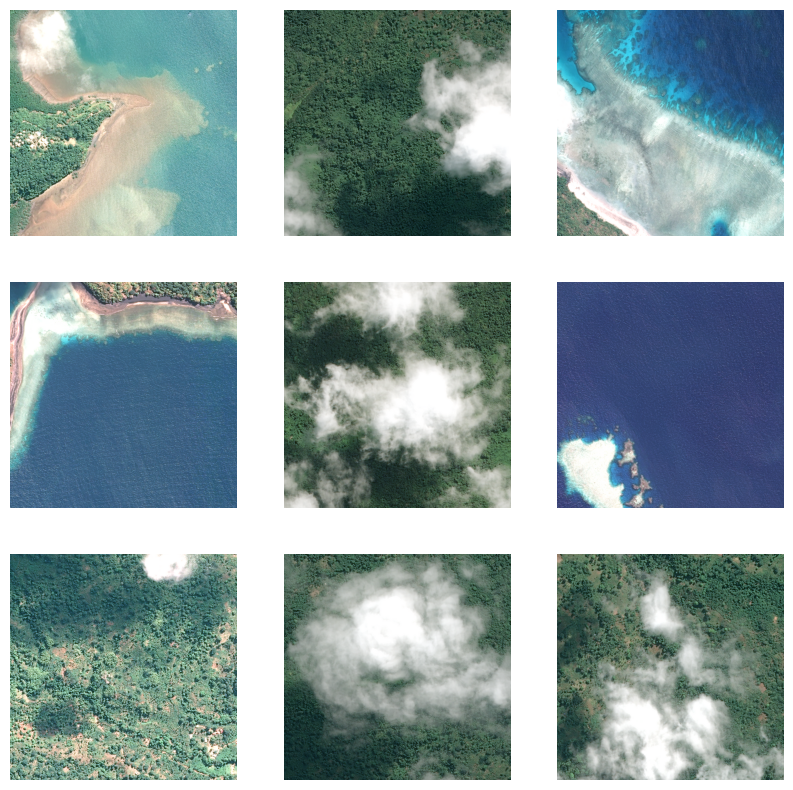

In [123]:
plot_list_path_square(nuages_echantillon[:9], "mayotte", 2020)

Dans l'échantillon, on a trouvé qu'il y a en réalité 6 nuages sur les 100 images sélectionnées et l'algorithme en a repéré 10. 

Cet algorithme va bien détecter toutes les images avec des nuages mais il va rajouter les images avec des étendues de blanc, par exemple les plages de sable blanc.

## Masque de nuages entiers

* Etape 1 : Détecter les images dans le dossier avec des nuages grâce aux seuils de coeur de nuage
* Etape 2 : Créer le masque nuage entier sur les images détectées étape 1
* Etape 3 : Définir les patchs contenant un nuage (et donc à éliminer de la bdd) pour chaque image avec masque nuage entier

On veut maintenant créer un masque nuage qui soit le plus proche de la réalité. Pour cela on va créer deux masques : l'un avec un seuil de niveau de gris élevé pour détecter le coeur du nuage, et l'autre avec un seuil de niveau de gris bas pour englober un maximum le nuage entier. Le deuxième masque va également repérer d'autres objets de type non nuage. Pour ne garder que les nuages, on va fusionner ces deux masques et garder uniquement les nuages entier sans les autres objets. Pour cela, on va transformer les masques en ensembles de polygones et retenir uniquement les polygones qui se chauvauchent sur les deux masques : ce seront les nuages entiers avec les coeurs de nuages. C'est comme ça que nous obtiendrons notre masque final de nuages entiers.

In [62]:
nuage_centre = mask_cloud(image_3, threshold = 250, min_size=50000)
nuage_centre

  0%|          | 1/412 [00:00<00:01, 244.27it/s]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

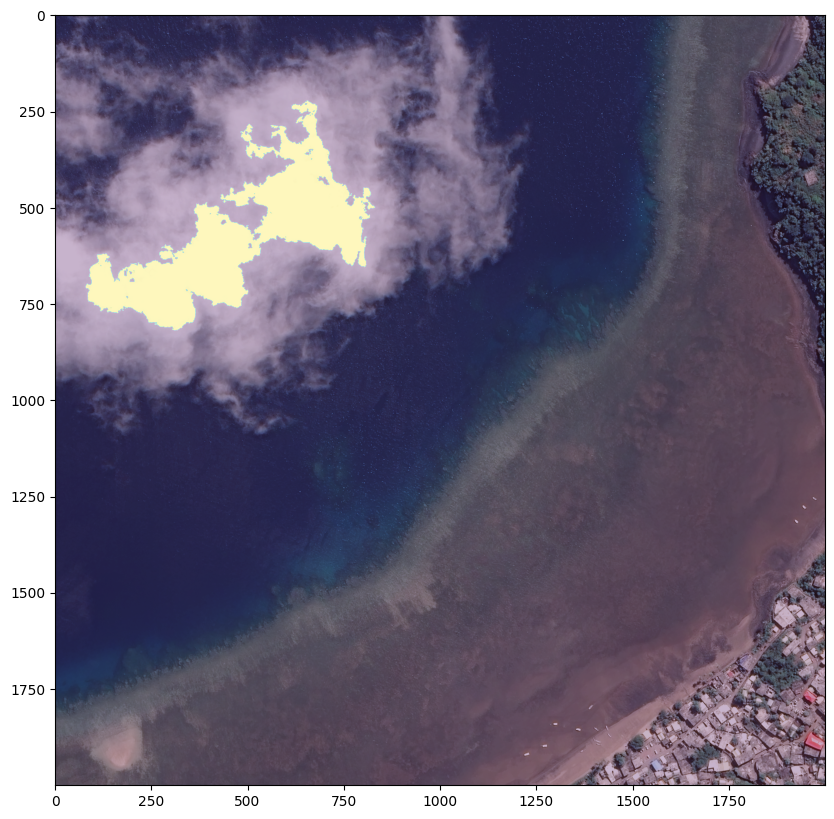

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image_3.array, (1, 2, 0))[:,:,:3])
ax.imshow(nuage_centre, alpha=0.3)

In [94]:
mask = mask_full_cloud(image_3, 250, 130, 50000)

  0%|          | 2/4164 [00:00<00:13, 316.84it/s]


In [115]:
def plot_mask(image, mask): 
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
    ax.imshow(mask, alpha=0.3)

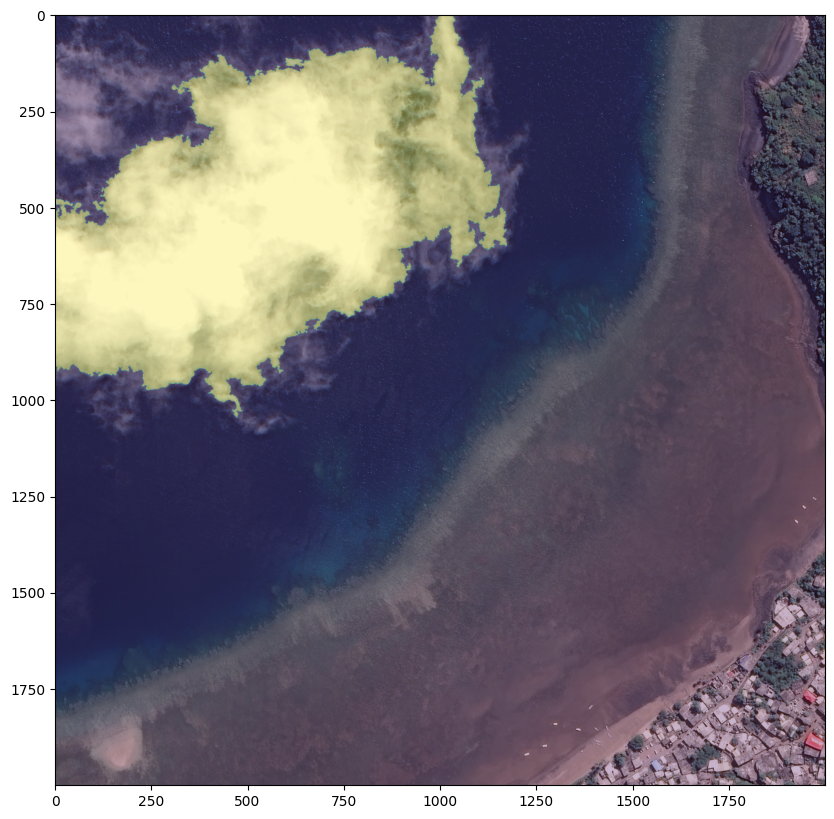

In [116]:
plot_mask(image_3, mask)

### Tests de masques sur d'autres images
Les images contenant des nuages de nuages_echantillon sont les i=2,3,4,5,8,9

  0%|          | 1/17303 [00:00<01:13, 234.57it/s]


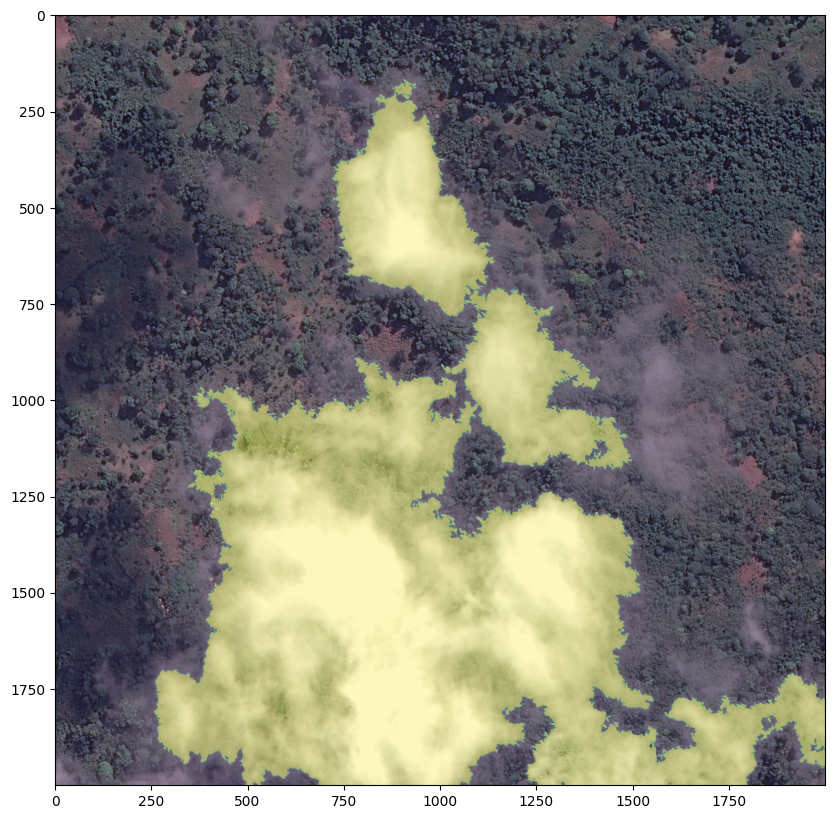

In [135]:
i=8
environment = get_environment()
folder_path = "../" + environment["local-path"]["PLEIADES"][2020]["mayotte"]
image_test = SatelliteImage.from_raster(
        folder_path + "/" + nuages_echantillon[i],
        date = date.fromisoformat('2020-01-01'), 
        n_bands = 3,
        dep = '976'
    )
image_test.normalize()
mask_test = mask_full_cloud(image_test)
plot_mask(image_test, mask_test)

### Test pour filter les patchs d'une image en même temps des nuages et des effets de bord

In [99]:
boolean = has_cloud(image_3)

if boolean:
    mask_full = mask_full_cloud(image_3)
    list_patch_filtered = patch_nocloud(image_3, mask_full, nb_patch = 250)
    list_patch_filtered = [patch for patch in list_patch_filtered if not is_too_black2(patch)]
else:
    list_patch_filtered = image_3.split(250)
    list_patch_filtered = [patch for patch in list_patch_filtered if not is_too_black2(patch)]

  0%|          | 4/2666 [00:00<00:13, 194.23it/s]


In [100]:
len(list_patch_filtered)

45

## Fonctions peut-être utiles

Fonction détection de nuage dans une liste de paths (au cas où)

In [53]:
def detect_nuage_list(list_filenames, dep, millesime, threshold, min_size):
    environment = get_environment()
    folder_path = "../" + environment["local-path"]["PLEIADES"][int(millesime)][dep.lower()]
    clouds = []
    num_dep = name_dep_to_num_dep[dep.upper()]
    
    for filename in tqdm(list_filenames):
        try :
            image = SatelliteImage.from_raster(
                    folder_path + '/' +filename,
                    date = date.fromisoformat(str(int(millesime))+'-01-01'), 
                    n_bands = 3,
                    dep = num_dep
                    )
            image.normalize()
            
            cloud = has_cloud(image)

            if cloud:
                clouds.append(filename, threshold, min_size)

        except RasterioIOError:
            print("L'image "+filename+" ne s'ouvre pas.")
            
        finally :
            continue
            
    return(nuages)